This is my solution to an exercise to make a spam classifier using Apache SpamAssassin’s public datasets, which I am writing to learn about machine learning. The exercise is from 
_Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition_, by
Aurélien Géron

Copyright (C) 2022 Chris March <https://github.com/chrismarch>

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

## Contents
- [Load and Preprocess](#Load-and-Preprocess)
- [Correlation Exploration](#Correlation-Exploration)
- [Training](#Training)
- [Scoring](#Scoring)
- [Tuning](#Tuning)
- [Submission](#Submission)

## Load and Preprocess

In [39]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
import re
import email
from email import policy

def load_email_files_to_csv():
    for parent_dir, subdirs, files in os.walk('.'):
        #print(parent_dir)
        #print(subdirs)
        #print('---')
        hamdir = '_ham' in parent_dir
        spamdir = 'spam' in parent_dir
        if hamdir or spamdir:
            for file in files:
                rel_file_path = os.path.join(parent_dir, file) 
                #print(rel_file_path)
                with open(rel_file_path, 'r', encoding='iso-8859-1') as f:
                    f_str = f.read()   
                    msg = email.message_from_string(f_str, policy=policy.default)
                    #print(msg['subject'])
                    print(msg.get_body())
                    return
load_email_files_to_csv()

Content-Type: text/html; charset=us-ascii
Content-Transfer-Encoding: 7bit

<HTML><HEAD><TITLE>Backup your DVD's</TITLE>
<META http-equiv=Content-Type content="text/html; charset=iso-8859-1">
<META content="MSHTML 6.00.2600.0" name=GENERATOR></HEAD>


<DIV></DIV>
<BLOCKQUOTE 
style="PADDING-RIGHT: 0px; PADDING-LEFT: 5px; MARGIN-LEFT: 5px; BORDER-LEFT: #000000 2px solid; MARGIN-RIGHT: 0px">
  <DIV></DIV>
  <TABLE cellSpacing=0 cellPadding=0 width=525 align=center bgColor=#ffffff 
  border=0>

    <TBODY> 
    <TR> 
      <TD width="33"><IMG height=1 src="images/spacer.gif" width=33 border=0></TD>
      <TD width="174"><IMG height=1 src="images/spacer.gif" width=174 border=0></TD>
      <TD width="360"><IMG height=1 src="images/spacer.gif" width=360 border=0></TD>
      <TD width="33"><IMG height=1 src="images/spacer.gif" width=33 border=0></TD>
    </TR>
    <TR> 
      <TD colSpan=4><a href="http://www.terra.es/personal9/iop1008/"><IMG height=253 src="http://www.terra.es/personal9/iop10

In [456]:



def load_csv_as_pd(csv_filename, data_path="."):
    csv_path = os.path.join(data_path, csv_filename)
    return pd.read_csv(csv_path)

class RegExTransformer(TransformerMixin):
    def __init__(self, col_idxs_to_regexes=[]): # no *args or **kargs
        self.col_idxs_to_regexes = col_idxs_to_regexes
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, Xdf):
        result = Xdf.copy()
        for col_idx_and_regex in self.col_idxs_to_regexes:
            col_idx = col_idx_and_regex[0]
            r = col_idx_and_regex[1]
            #print(result[:,col_idx])
            #print(result[0][col_idx])
            #print(r.search(result[0][col_idx]).group(0))
            new_result = []
            for row in result[col_idx]:
                title = r.search(str(row))
                title = title.group(0) if title else None
                new_result.append(title)
            #print(new_result)
            result[col_idx] = new_result
        return result

rc_name = re.compile(r"[\w]+(?=\.)")
rc_ticket = re.compile(r"(\d+)(?!.*\d)")
re_cat_tr = RegExTransformer(col_idxs_to_regexes=[("Name", rc_name)])
re_num_tr = RegExTransformer(col_idxs_to_regexes=[("Ticket", rc_ticket)])


def preprocess_data(data):    
    drop_attribs = ['PassengerId', "Cabin"]
    pp = data.drop(drop_attribs, axis=1)
    return re_cat_tr.transform(pp)
    
all_train_data = load_csv_as_pd("train.csv")
all_train_data_pp = preprocess_data(all_train_data)

name_set = set(all_train_data_pp["Name"])
name_set.add('Dona') # test.csv only
name_categories = list(name_set)
sex_categories = list(set(all_train_data_pp["Sex"]))
embarked_categories = list(set(all_train_data_pp["Embarked"]))
all_categories = [name_categories, sex_categories, embarked_categories]
print(all_categories)
                                
target_label_col = "Survived"
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indexes, test_indexes in split.split(all_train_data_pp, all_train_data_pp[target_label_col]):
    strat_train_set = all_train_data_pp.loc[train_indexes]
    strat_test_set = all_train_data_pp.loc[test_indexes]

#strat_test_set["income_cat"].value_counts() / len(strat_test_set)

print(list(strat_train_set))
X_train = strat_train_set.drop(target_label_col, axis=1)
y_train = strat_train_set[target_label_col].copy()

# test data split from train.csv, since test.csv has no labels
X_test = strat_test_set.drop(target_label_col, axis=1)
y_test = strat_test_set[target_label_col].copy()

print(X_train.shape)
X_train.iloc[0]
X_train["Name"]

[['Miss', 'Mr', 'Lady', 'Mrs', 'Ms', 'Don', 'Capt', 'Rev', 'Mlle', 'Jonkheer', 'Dona', 'Master', 'Mme', 'Col', 'Dr', 'Major', 'Sir', 'Countess'], ['male', 'female'], ['Q', 'C', 'S', nan]]
['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']
(712, 9)


692      Mr
481      Mr
527      Mr
855     Mrs
801     Mrs
       ... 
359    Miss
258    Miss
736     Mrs
462      Mr
507      Mr
Name: Name, Length: 712, dtype: object

## Correlation Exploration

In [517]:
drop_attribs_cor = ["PassengerId", "Cabin"] # FIXME parse Cabin?
X_cor = train.drop(drop_attribs_cor, axis=1)
print(list(X_cor))
num_attribs_cor = ['Survived', 'Pclass', "Ticket", 'Age', 'SibSp', 'Parch', 'Fare']
cat_attribs_cor = ["Name", 'Sex', 'Embarked']


['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']


In [519]:
X_cor_tr = re_num_tr.transform(re_cat_tr.transform(X_cor))
print(X_cor_tr)

     Survived  Pclass  Name     Sex   Age  SibSp  Parch   Ticket     Fare  \
0           0       3    Mr    male  22.0      1      0    21171   7.2500   
1           1       1   Mrs  female  38.0      1      0    17599  71.2833   
2           1       3  Miss  female  26.0      0      0  3101282   7.9250   
3           1       1   Mrs  female  35.0      1      0   113803  53.1000   
4           0       3    Mr    male  35.0      0      0   373450   8.0500   
..        ...     ...   ...     ...   ...    ...    ...      ...      ...   
886         0       2   Rev    male  27.0      0      0   211536  13.0000   
887         1       1  Miss  female  19.0      0      0   112053  30.0000   
888         0       3  Miss  female   NaN      1      2     6607  23.4500   
889         1       1    Mr    male  26.0      0      0   111369  30.0000   
890         0       3    Mr    male  32.0      0      0   370376   7.7500   

    Embarked  
0          S  
1          C  
2          S  
3          S  


In [520]:
num_pipe_cor = Pipeline([
        ('regex', re_num_tr),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipe_cor = Pipeline([    
        ('one', OneHotEncoder(categories=all_categories)),
    ])

col_trans_cor = ColumnTransformer([
        ("num", num_pipe_cor, num_attribs_cor),
        ("cat", cat_pipe_cor, cat_attribs_cor),
    ])

col_trans_cor.fit(X_cor_tr, y_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('regex',
                                                  <__main__.RegExTransformer object at 0x147047fd0>),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['Survived', 'Pclass', 'Ticket', 'Age',
                                  'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('one',
                                                  OneHotEncoder(categories=[['Miss',
                                                                             'Mr',
                                                                             'Lady',
                                 

## Correlation to Survived

In [542]:
#corr_matrix = trcp.corr()
#print(corr_matrix["Survived"].sort_values(ascending=False))

#print(trcp.iloc[0])
trtr = col_trans_cor.transform(all_train_data_pp)
#print(main_pipeline.named_steps['col'].transformers_[0][1].get_feature_names_out())
#print(col_trans_cor.transformers_[1][1].named_steps['one'].get_feature_names_out())
onehot_attribs_cor = col_trans_cor.transformers_[1][1].named_steps['one'].get_feature_names_out()
#print(col_trans.named_steps["cat"].get_feature_names_out())

#print(trtr[0])
all_attribs = list(trcp)
#print(all_attribs)
#print(num_attribs_cor)
#print(onehot_attribs_cor)
tr_attribs = list(num_attribs_cor) + list(onehot_attribs_cor)
trc = pd.DataFrame(trtr, columns=tr_attribs)
#print(trc.iloc[0])
cor_matrix = trc.corr()
label_cor = cor_matrix[target_label_col] #.sort_values(ascending=False)
#print(label_cor)
label_cor = np.abs(label_cor) #.sort_values(ascending=False)
#print(label_cor)
list(zip(label_cor.to_numpy(), tr_attribs))
sorted(zip(label_cor.to_numpy(), tr_attribs), reverse=True)

[(1.0, 'Survived'),
 (0.549199184903008, 'Name_Mr'),
 (nan, 'Name_Dona'),
 (0.5433513806577553, 'Sex_male'),
 (0.5433513806577552, 'Sex_female'),
 (0.3390402513843201, 'Name_Mrs'),
 (0.33848103596101486, 'Pclass'),
 (0.32709254908267804, 'Name_Miss'),
 (0.25730652238496216, 'Fare'),
 (0.16824043121823318, 'Embarked_C'),
 (0.15566027340439353, 'Embarked_S'),
 (0.09584394138296883, 'Ticket'),
 (0.08522056083929429, 'Name_Master'),
 (0.08162940708348335, 'Parch'),
 (0.06498765565557561, 'Name_Rev'),
 (0.06491041993052599, 'Age'),
 (0.060094847378356624, 'Embarked_nan'),
 (0.060094847378356575, 'Name_Mlle'),
 (0.042469594647755314, 'Name_Countess'),
 (0.0424695946477553, 'Name_Ms'),
 (0.04246959464775528, 'Name_Sir'),
 (0.04246959464775528, 'Name_Mme'),
 (0.04246959464775528, 'Name_Lady'),
 (0.035322498885735513, 'SibSp'),
 (0.026456468796962375, 'Name_Don'),
 (0.02645646879696235, 'Name_Capt'),
 (0.02645646879696234, 'Name_Jonkheer'),
 (0.01132935647296889, 'Name_Major'),
 (0.011329356472

## Training

In [543]:
#drop_attribs = ["Survived", "PassengerId", "Name", "Ticket", "Cabin"] # FIXME parse
#drop_attribs = ['PassengerId', "Cabin"]
#print(list(X_train))
#X_train = train.drop(drop_attribs, axis=1)
#print(list(X_train))
#cat_attribs = {"Sex", "Embarked"}
#cat_attribs = {"Sex"}
#num_attribs = list(set(X_train) - cat_attribs)
#cat_attribs = list(cat_attribs)

num_attribs = ['Pclass', "Ticket", 'Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ["Name", 'Sex', 'Embarked']

## Training Pipeline
### And Estimator Scoring

In [457]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

num_pipe_cor = Pipeline([
        ('regex', re_num_tr),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipe_cor = Pipeline([    
        ('one', OneHotEncoder(categories=all_categories)),
    ])

col_trans = ColumnTransformer([
        ("num", num_pipe_cor, num_attribs),
        ("cat", cat_pipe_cor, cat_attribs),
    ])

X_train_tr = col_trans.fit_transform(X_train)

lin_class = LinearRegression()
svc_class = SVC(random_state=42)
forest_class = RandomForestClassifier(random_state=42)
knn_class = KNeighborsClassifier()
sgd_class = SGDClassifier(random_state=42, shuffle=True)
                          
def display_scores(scores):
     print("Scores:", scores)
     print("Mean:", scores.mean())
     print("Standard deviation:", scores.std())
        
def display_estimator_cv_scores(estimator, X, y): 
    scores = cross_val_score(estimator, X, y,
                             scoring="neg_mean_squared_error", cv=10)
    display_estimator_scores(estimator, scores)

def display_estimator_scores(estimator, scores):    
    rmse_scores = np.sqrt(-scores)
    print("\n")
    print(type(estimator).__name__)
    display_scores(rmse_scores)

display_estimator_cv_scores(lin_class, X_train_tr, y_train)
display_estimator_cv_scores(svc_class, X_train_tr, y_train)
display_estimator_cv_scores(knn_class, X_train_tr, y_train)
display_estimator_cv_scores(forest_class, X_train_tr, y_train)
display_estimator_cv_scores(sgd_class, X_train_tr, y_train)

main_pipeline = Pipeline([
    ('col', col_trans),
#    ('dropper', AttributesDropper()),
#    ('forest', )
#     ('knn', knn_class)    
#         ('sgd', SGDClassifier(random_state=42))    
])

#pipe_out = main_pipeline.fit(X_train, y_train)




LinearRegression
Scores: [0.42951581 0.36875083 0.3428164  0.39119238 0.36635647 0.36865981
 0.3255011  0.3482566  0.42931634 0.35573601]
Mean: 0.3726101742601956
Standard deviation: 0.032944675772515586


SVC
Scores: [0.5        0.40824829 0.41111323 0.45963856 0.39361095 0.41111323
 0.37529331 0.44405304 0.45963856 0.39361095]
Mean: 0.42563201037789955
Standard deviation: 0.036730489118299084


KNeighborsClassifier
Scores: [0.47140452 0.45643546 0.31399291 0.47471266 0.39361095 0.41111323
 0.3560345  0.44405304 0.50350881 0.44405304]
Mean: 0.4268919118204534
Standard deviation: 0.0554289843366664


RandomForestClassifier
Scores: [0.45643546 0.45643546 0.37529331 0.50350881 0.39361095 0.3560345
 0.33567254 0.39361095 0.47471266 0.37529331]
Mean: 0.412060796690943
Standard deviation: 0.05346477335638679


SGDClassifier
Scores: [0.52704628 0.5        0.44405304 0.53074489 0.54385168 0.50350881
 0.48932261 0.53074489 0.54385168 0.44405304]
Mean: 0.5057176917654667
Standard deviation: 0

## Tuning

In [569]:
attr_importance_forest = [(0.0648981362279047, 'Pclass'),
 (0.21639081922537215, 'Ticket'),
 (0.14208543718190852, 'Age'),
 (0.03568391303899273, 'SibSp'),
 (0.025137625725799348, 'Parch'),
 (0.16131382293371863, 'Fare'),
 (0.020349299107887405, 'Name_Miss'),
 (0.08672537975760944, 'Name_Mr'),
 (5.516785381739478e-05, 'Name_Lady'),
 (0.02612759603492212, 'Name_Mrs'),
 (5.443890925888659e-05, 'Name_Ms'),
 (0.0014568613145544734, 'Name_Don'),
 (0.0, 'Name_Capt'),
 (0.002200667222420063, 'Name_Rev'),
 (0.00012068645145299442, 'Name_Mlle'),
 (0.00027993224708287395, 'Name_Jonkheer'),
 (0.01030580603442299, 'Name_Master'),
 (0.0, 'Name_Mme'),
 (0.0003735328721120903, 'Name_Col'),
 (0.0020951989380721438, 'Name_Dr'),
 (0.0020724191145251075, 'Name_Major'),
 (0.000446946023234743, 'Name_Sir'),
 (0.0, 'Name_Countess'),
 (0.11141408720580068, 'Sex_male'),
 (0.058142929271631165, 'Sex_female'),
 (0.0067307923675844206, 'Embarked_Q'),
 (0.011811320381569958, 'Embarked_C'),
 (0.013677565286613564, 'Embarked_S'),
 (4.9619271731465136e-05, 'Embarked_nan')]

attr_correlation = [(1.0, 'Survived'),
 (0.33848103596101486, 'Pclass'),
 (0.09584394138296883, 'Ticket'),
 (0.06491041993052599, 'Age'),
 (0.035322498885735513, 'SibSp'),
 (0.08162940708348335, 'Parch'),
 (0.25730652238496216, 'Fare'),
 (0.32709254908267804, 'Name_Miss'),
 (0.549199184903008, 'Name_Mr'),
 (0.04246959464775528, 'Name_Lady'),
 (0.3390402513843201, 'Name_Mrs'),
 (0.0424695946477553, 'Name_Ms'),
 (0.026456468796962375, 'Name_Don'),
 (0.02645646879696235, 'Name_Capt'),
 (0.06498765565557561, 'Name_Rev'),
 (0.060094847378356575, 'Name_Mlle'),
 (0.02645646879696234, 'Name_Jonkheer'),
 (0, 'Name_Dona'),
 (0.08522056083929429, 'Name_Master'),
 (0.04246959464775528, 'Name_Mme'),
 (0.01132935647296888, 'Name_Col'),
 (0.008185209987623298, 'Name_Dr'),
 (0.01132935647296889, 'Name_Major'),
 (0.04246959464775528, 'Name_Sir'),
 (0.042469594647755314, 'Name_Countess'),
 (0.5433513806577553, 'Sex_male'),
 (0.5433513806577552, 'Sex_female'),
 (0.003650382683972212, 'Embarked_Q'),
 (0.16824043121823318, 'Embarked_C'),
 (0.15566027340439353, 'Embarked_S'),
 (0.060094847378356624, 'Embarked_nan')]

'''
class AttributesDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_top_to_keep=30): # no *args or **kargs
        self.n_top_to_keep = n_top_to_keep
        self.cols_to_drop = attr_correlation[0:self.n_top_to_keep]
                
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        self.cols_to_drop = attr_correlation[0:self.n_top_to_keep]
        return np.delete(X, self.cols_to_drop, 1)
'''

class AttributesDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, min_importance=0.01): # no *args or **kargs
        self.min_importance = min_importance
        self.cols_to_drop = []
        for i, t in enumerate(attr_importance_forest):
            #print(i, t)
            if t[0] < self.min_importance:
                self.cols_to_drop.append(i)
        #print(self.cols_to_drop)
                
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        self.cols_to_drop = []
        for i, t in enumerate(attr_importance_forest):
            if i >= np.size(X, 1):
                continue
            #print(i, t)
            if t[0] < self.min_importance:
                self.cols_to_drop.append(i)
                
        #print(self.cols_to_drop)
        #print(X)
        return np.delete(X, self.cols_to_drop, 1)

In [570]:
forest_param_grid = [
    {'n_estimators': [40, 35, 45], 'max_features': [None, "sqrt", "log2"]},
    {'bootstrap': [False], 'n_estimators': [40, 35, 45], 'max_features': [None, "sqrt", "log2"]},
  ]

knn_param_grid = [
    {'weights': ["uniform", "distance"], 'n_neighbors': [5, 8, 9, 10, 11, 15, 20, 100]},
  ]

sgd_param_grid = [
    {'loss': ["hinge", "log", "modified_huber", "squared_hinge", "perceptron", "squared_error", "huber", 
              "epsilon_insensitive", "squared_epsilon_insensitive"], 
     'penalty': ["l2", "l1", "elasticnet"],
    'max_iter' : [500, 600, 400]}
  ]

grid_search = GridSearchCV(knn_class,knn_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=1)

#col_trans.named_transformers_["cat"].handle_unknown = 'ignore' # for dropping attributes

main_pipeline = Pipeline([
    ('col', col_trans),
    ('dropper', AttributesDropper()),
#    ('forest', )
#     ('knn', knn_class)    
#         ('sgd', SGDClassifier(random_state=42))    
 #   ('dropper', AttributesDropper()),
    ('grid', grid_search)
])

param_drpr = [
#    {'dropper__min_importance': [0,.0002,.0004,.00005,.0003]}
    {'dropper__min_importance': [0, .061, .07, .08]}

     #{'col__verbose': [1,2]}
  ]

full_pipeline = GridSearchCV(main_pipeline, param_drpr, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=2)#, error_score='raise')

In [571]:
pipe_out = full_pipeline.fit(X_train, y_train)
#pipe_out = main_pipeline.fit(X_train, y_train)
#print(grid_search.best_params_)
print(full_pipeline.best_params_)
print(full_pipeline.best_estimator_.steps[2][1].best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................dropper__min_importance=0.061; total time=   0.9s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................

## Scoring

In [572]:
#X_test_tr = col_trans.fit_transform(X_test)
#print(list(X_train))
#print(list(X_test))

# forest
# 0.785314498933902
# 0.7706711343254163 drop age

# knn
# 0.7795566502463054

# sgd
# 0.777129750982962

y_test_predict = pipe_out.predict(X_test)
score = f1_score(y_test, y_test_predict, average="macro")
score

0.7795566502463054

## RandomForestClassifier.feature_importances_

In [561]:

feature_importances = full_pipeline.best_estimator_.steps[2][1].best_estimator_.feature_importances_
#feature_importances = grid_search.best_estimator_.feature_importances_
#feature_importances

#print(feature_importances)

#cat_encoder = col_pipeline.named_transformers_["cat"]
onehot_attribs = col_trans.transformers_[1][1].named_steps['one'].get_feature_names_out()
#print(onehot_attribs)
#print(num_attribs)
attributes = num_attribs + list(onehot_attribs)
#list(zip(feature_importances, attributes))
sorted(zip(feature_importances, attributes), reverse=True)

[(0.24642056362521655, 'Ticket'),
 (0.1997771812616029, 'SibSp'),
 (0.1625302744959772, 'Age'),
 (0.1310349683247463, 'Name_Mrs'),
 (0.12822693304238728, 'Fare'),
 (0.06365665124579165, 'Pclass'),
 (0.037023662731619195, 'Parch'),
 (0.020000375176989427, 'Name_Don'),
 (0.010536099549008712, 'Name_Ms'),
 (0.0004413942038337618, 'Name_Capt'),
 (0.000299882278765768, 'Name_Mr'),
 (5.20140640613997e-05, 'Name_Miss'),
 (0.0, 'Name_Lady')]

## Performance
### ROC Curve

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................dropper__min_importance=0.061; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................

[CV] END .......................dropper__min_importance=0.08; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................dropper__min_importance=0.08; total time=   0.8s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................dropper__min_importance=0.08; total time=   0.8s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................dropper__min_importance=0.08; total time=   0.8s
Fitting 5 folds for each of 16 candidates, totalling 80 fits


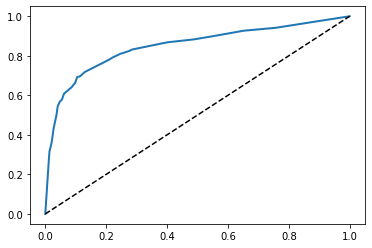

0.8486528657371482

In [573]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

y_scores = cross_val_predict(pipe_out, X_train, y_train, cv=3,
                             method="predict_proba")
                             #method="decision_function") #SGD
    
y_scores = y_scores[:, 1]   # score = proba of positive class

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()
# forest
# 0.856909225929727
# 0.8557619297938204 drop age

# knn
# 0.8406051048420068

# sgd
# n/a

roc_auc_score(y_train, y_scores)

## Submission

In [468]:
lin_class_test = LinearRegression()
svc_class_test = SVC(random_state=42)
forest_class_test = RandomForestClassifier(random_state=42)
knn_class_test = KNeighborsClassifier()
sgd_class_test = SGDClassifier(random_state=42, shuffle=True)

In [514]:
grid_search_test = GridSearchCV(knn_class_test, knn_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=1)

#col_trans.named_transformers_["cat"].handle_unknown = 'ignore' # for dropping attributes

main_pipeline_test = Pipeline([
    ('col', col_trans),
    ('dropper', AttributesDropper()),
    ('grid', grid_search_test)
])

full_pipeline_test = GridSearchCV(main_pipeline_test, param_drpr, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=2)#, error_score='raise')

In [515]:
all_test_data = load_csv_as_pd("test.csv")
all_test_data_pp = preprocess_data(all_test_data)

X_train_all = all_train_data_pp.drop(target_label_col, axis=1)
y_train_all = all_train_data_pp[target_label_col].copy()

pipe_out_test = full_pipeline_test.fit(X_train_all, y_train_all)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.5s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.5s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.5s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.5s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................dropper__min_importance=0.0002; total time=   1.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................

In [516]:
print(full_pipeline_test.best_params_)
#print(full_pipeline_test.best_estimator_)
print(full_pipeline_test.best_estimator_.steps[2][1].best_params_)

#print(grid_search_test.named_steps['grid'].best_params_)
y_submission = pipe_out_test.predict(all_test_data_pp)
print(y_submission.shape)

df = pd.DataFrame(y_submission, columns=['Survived'])
df.insert(0, "PassengerId", all_test_data["PassengerId"], allow_duplicates=True)
df.to_csv("submission.csv", index=False)
df

{'dropper__min_importance': 0.0004}
{'n_neighbors': 10, 'weights': 'uniform'}
(418,)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


1. 0.75119: forest trained on subset of train.csv
2. 0.75598: forest trained on all data
3. 0.77751: knn .0001 drop?
4. 0.72966: sgd
5. 0.77751: knn .0003 drop
6. 0.77033: knn .00001 drop
7. 0.77751: knn .0004 drop